# Script for kaggle titanic competition

## Functions

In [1]:
##Rescaling Function
def rescale_function(scaling_fn, data_frame, variable):
    '''Function for rescaling a dataframe variable

    The scaling function should be fitted before use
    '''
    data_frame_copy = data_frame.copy()

    data_frame_var_scaled = scaling_fn.transform(data_frame[variable].values.reshape(-1,1))
    data_frame_copy[variable] = data_frame_var_scaled

    return data_frame_copy

## Main Script

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from numpy import array as nparr
from numpy import zeros
from scipy.stats import chi2_contingency
from numpy import savetxt as npsavetxt
from numpy import where as npwhere
from numpy import empty as npempty
from numpy import argmax as npargmax
import csv
import ast

In [3]:
RANDOM_STATE = 10203

## Sorting out the dataframe

In [4]:
#Reading in the raw data
df = pd.read_csv('train.csv', index_col = 0)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Cleaning the data

In [5]:
#Counting the instances of missingness in each column
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [6]:
#Looking at the different column types
for col in df.columns:
    print(
        '''{}
        Unique classes: {}
        Data Type: {}'''.format(
            col,
            len(df[col].unique()),
            df[col].dtype
        )
    )
 

Survived
        Unique classes: 2
        Data Type: int64
Pclass
        Unique classes: 3
        Data Type: int64
Name
        Unique classes: 891
        Data Type: object
Sex
        Unique classes: 2
        Data Type: object
Age
        Unique classes: 89
        Data Type: float64
SibSp
        Unique classes: 7
        Data Type: int64
Parch
        Unique classes: 7
        Data Type: int64
Ticket
        Unique classes: 681
        Data Type: object
Fare
        Unique classes: 248
        Data Type: float64
Cabin
        Unique classes: 148
        Data Type: object
Embarked
        Unique classes: 4
        Data Type: object


The following data can be removed, as there are too many instances for it to be useful;
- Name
- Ticket

Cabin will also be removed because most of the data points do not have data on this, so interpolating values would not be helpful.

The passengers without embarked data will also be dropped, because there are only 2 of them. The embarked and sex columns will then be one-hot encoded.\

There are enough passengers without age to warrent further investigation.

In [7]:
#Dropping Cabin
df = df.drop(['Cabin', 'Name','Ticket'], axis = 1)

# Removing Embarked NA values
df = df[df.Embarked.notna()]

#One-hot encoding Sex 1 = male, 0 = female
df['Sex'] = pd.get_dummies(df['Sex'])['male']

#Converting Embarked into 00 = S, 10 = C and 01 = Q
df = pd.concat([df,pd.get_dummies(df['Embarked'])[['C','Q']]], axis = 1).drop('Embarked', axis = 1)
df.rename(columns = {'C':'Embarked1','Q':'Embarked2'},inplace = True)

#One-hot encoding Embarked

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked1,Embarked2
PassengerId,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,0,0
2,1,1,0,38.0,1,0,71.2833,1,0
3,1,3,0,26.0,0,0,7.9250,0,0
4,1,1,0,35.0,1,0,53.1000,0,0
5,0,3,1,35.0,0,0,8.0500,0,0


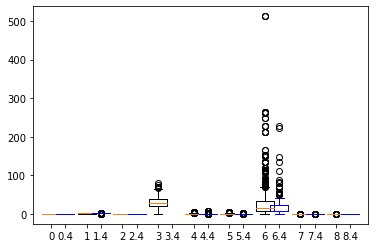

In [8]:
# Looking at the spread of variables for w and w/o age information
df_age = df[df.Age.notna()]
df_age_na = df[df.Age.isna()]

pos = nparr(range(len(df.columns)))

# Plotting
plt.boxplot(df_age, positions = pos);


edge_color = 'blue'
bp = plt.boxplot(df_age_na, positions = pos + 0.4);

#Changing the colour, taken from StackOverflow Q477486
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

In [9]:
#Looking specifically at the survival data, and the proportion in each class

nparr(df_age.Survived == 1).sum()
nparr(df_age.Survived == 0).sum()
df_age.shape[0]

print('''Age Data\nSurvived = {:.3f},\nNot Survived = {:.3f}\n\n
No Age Data\nSurvived = {:.3f},\nNotSurvived = {:.3f}'''.format(
    nparr(df_age.Survived == 1).sum()/df_age.shape[0],
    nparr(df_age.Survived == 0).sum()/df_age.shape[0],
    nparr(df_age_na.Survived == 1).sum()/df_age_na.shape[0],
    nparr(df_age_na.Survived == 0).sum()/df_age_na.shape[0]
)
     )


Age Data
Survived = 0.404,
Not Survived = 0.596


No Age Data
Survived = 0.294,
NotSurvived = 0.706


The survival data for age/no age is not clear, so a chi-squared test will be done to see if there is statistical significance.

In [10]:
#Making the contingency table cols = Age Data, No Age Data, rows = survived, didn't survive
contingency_table = nparr(
    [[nparr(df_age.Survived == 1).sum(),nparr(df_age.Survived == 0).sum()],
    [nparr(df_age_na.Survived == 1).sum(),nparr(df_age_na.Survived == 0).sum()]]).T

print(contingency_table)

chi2, p, _, _ = chi2_contingency(contingency_table)

print('Chi^2 Statistic: {:.3f},\np-value: {:.3f}'.format(
    chi2, p))

[[288  52]
 [424 125]]
Chi^2 Statistic: 6.895,
p-value: 0.009


So, there is a less than 1% chance that the data with and without age is from the same dataset, and thus 2 different statistical learning methods will need to be implemented, depending on if age is available or not.

In [11]:
#Extracting the survived as a separate column
survived = df['Survived']

#Removing survived and name of passengers from dataframe
df = df.drop(['Survived'], axis = 1)


In [12]:
#Splitting the Age/No Age
df_age = df[df.Age.notna()]
df_no_age = df[df.Age.isna()]

survived_age = survived[df.Age.notna()]
survived_no_age = survived[df.Age.isna()]

df_no_age = df_no_age.drop('Age', axis = 1)

In [13]:
df_age.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked1,Embarked2
PassengerId,,,,,,,,
1,3,1,22.0,1,0,7.2500,0,0
2,1,0,38.0,1,0,71.2833,1,0
3,3,0,26.0,0,0,7.9250,0,0
4,1,0,35.0,1,0,53.1000,0,0
5,3,1,35.0,0,0,8.0500,0,0


In [14]:
df_no_age.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked1,Embarked2
PassengerId,,,,,,,
6,3,1,0,0,8.4583,0,1
18,2,1,0,0,13.0000,0,0
20,3,0,0,0,7.2250,1,0
27,3,1,0,0,7.2250,1,0
29,3,0,0,0,7.8792,0,1


In [15]:
#Splitting the data into test train

#Age data
X_age_train, X_age_test, y_age_train, y_age_test = train_test_split(
    df_age, survived_age, test_size = 0.25, random_state = RANDOM_STATE)

#No Age data (nage)
X_nage_train, X_nage_test, y_nage_train, y_nage_test = train_test_split(
    df_no_age, survived_no_age, test_size = 0.25, random_state = RANDOM_STATE)

names = ['Age data','No Age data']

## Analysing the data

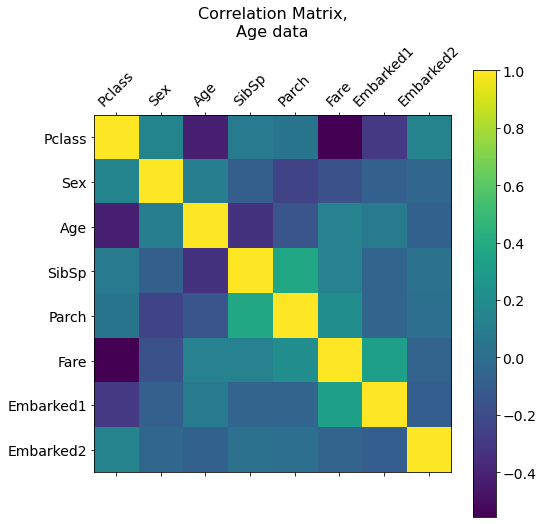

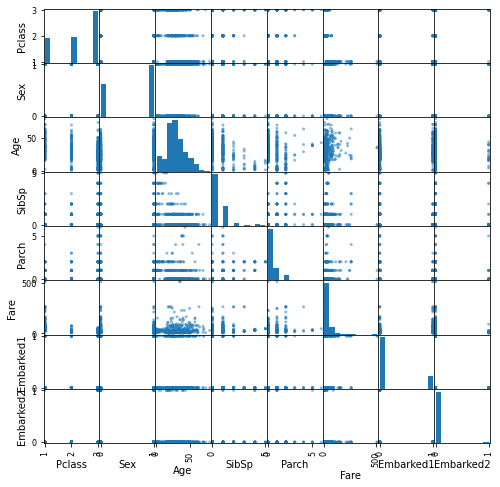

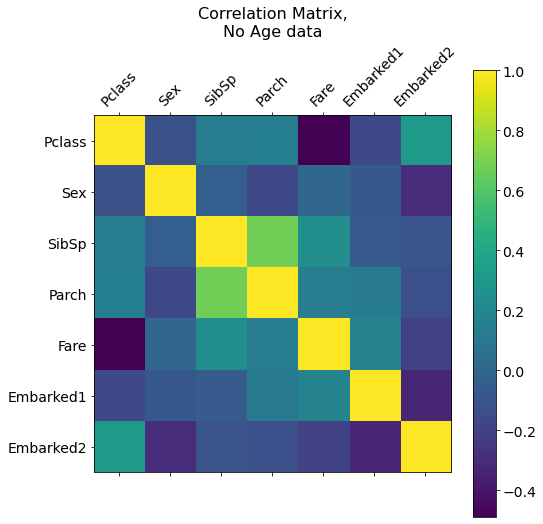

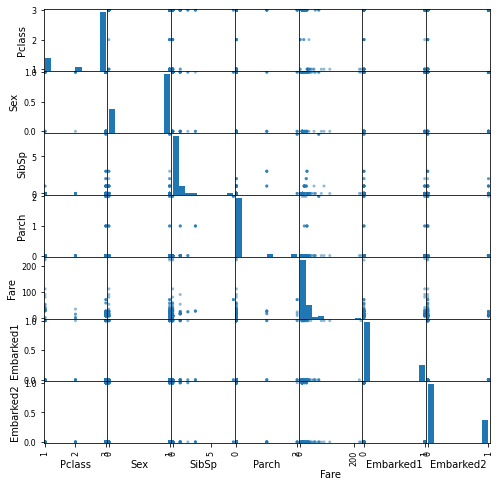

In [16]:
X_train = [X_age_train, X_nage_train]

for X_train, name in zip([X_age_train, X_nage_train], names):
    
    #Plotting correlation matrix
    f = plt.figure(figsize=(8, 8))
    plt.matshow(X_train.corr(), fignum=f.number)
    plt.xticks(range(X_train.select_dtypes(['number']).shape[1]), X_train.select_dtypes(['number']).columns, fontsize=14, rotation=45)
    plt.yticks(range(X_train.select_dtypes(['number']).shape[1]), X_train.select_dtypes(['number']).columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix,\n{}'.format(name), fontsize=16);
    
    #Plotting the scatter matrix
    pd.plotting.scatter_matrix(X_train,
                          figsize = (8,8)
                          );

For both sets of data, it appears that none of the variables are highly correlated with one another.

Very few of them seem to be normally distributed.

The scale also needs to be addressed.

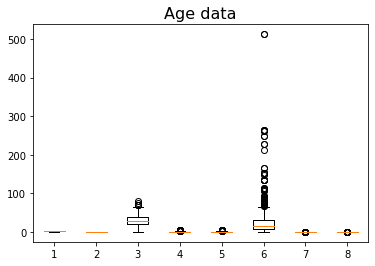

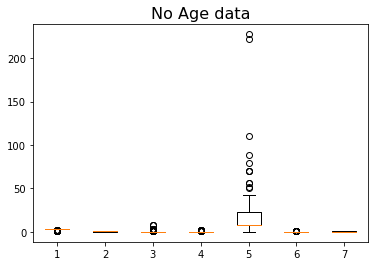

<Figure size 432x288 with 0 Axes>

In [17]:
for X_train, name in zip([X_age_train, X_nage_train], names):

    plt.boxplot(X_train)
    plt.title(name, fontsize = 16)
    plt.figure()   


For No Age data; fare will need to be rescaled

For Age data; both age and fare need to be rescaled.

Age will be rescaled with a minmax scaler, as it is fairly normally distributed and doesn't have too many outliers.
Fare will be rescaled with a quantile transformer, to give a distribution between 0 and 1

In [18]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer

In [19]:
#Rescaling Age
mmscaler = MinMaxScaler()
mmscaler.fit(X_age_train['Age'].values.reshape(-1,1))

X_age_train = rescale_function(scaling_fn = mmscaler,
                               data_frame = X_age_train,
                               variable = 'Age')
X_age_test = rescale_function(scaling_fn = mmscaler,
                              data_frame = X_age_test,
                              variable = 'Age')

In [20]:
#Rescaling Fare
qtscaler_age = QuantileTransformer()

#Age data
qtscaler_age.fit(X_age_train['Fare'].values.reshape(-1,1))
X_age_train = rescale_function(scaling_fn = qtscaler_age,
                               data_frame = X_age_train,
                               variable = 'Fare')
X_age_test = rescale_function(scaling_fn = qtscaler_age,
                              data_frame = X_age_test,
                              variable = 'Fare')

qtscaler_nage = QuantileTransformer()

#No Age Data
qtscaler_nage.fit(X_nage_train['Fare'].values.reshape(-1,1))
X_nage_train = rescale_function(scaling_fn = qtscaler_nage,
                                data_frame = X_nage_train,
                                variable = 'Fare')
X_nage_test = rescale_function(scaling_fn = qtscaler_nage,
                               data_frame = X_nage_test,
                               variable = 'Fare')

C:\Users\ucnvtpo\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (534). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "
C:\Users\ucnvtpo\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (132). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "


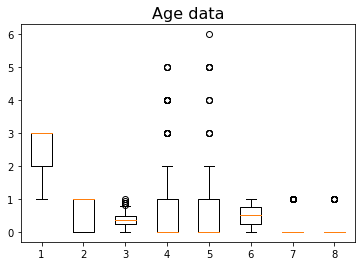

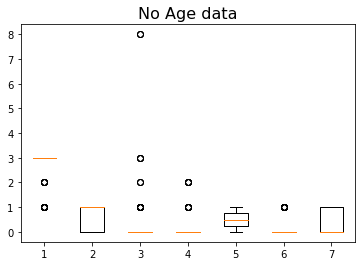

<Figure size 432x288 with 0 Axes>

In [21]:
for X_train, name in zip([X_age_train, X_nage_train], names):

    plt.boxplot(X_train)
    plt.title(name, fontsize = 16)
    plt.figure();  


Both sets of data now look much better scaled, and so should now be ready to 

## Predictions

Will use different statistical/machine learning techniques to predict the outcome of the passengers onboard the titanic.

Methods used;
- Logistic Regression
    - Will perform a grid search over the C values (regularisation strength). For a data set like this, with only a small number of variables, this may not make too much difference
- Support Vector Machines
    - For SVM, will tune nu, kernel, degree, gamma
- Random Forest
    - For random forest, the hyperparameter tuning will be over the criterion, min_sample_split, min_samples_leaf
- Nearest Neighours
    - For NN, we will hyperparameter tune the number of neighbours

We will iterate through the methods, with a hyperparameter search for each method done over the relavent variables.

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [23]:
toggle_new_array = True

In [24]:
X_train = [X_age_train, X_nage_train]
X_test = [X_age_test, X_nage_test]
y_train = [y_age_train, y_nage_train]
y_test = [y_age_test, y_nage_test]

In [48]:
methods = ['Logistic Regression',
#           'SVM',
           'Random Forest',
           'Nearest Neighbours'
          ]

if toggle_new_array:
    test_accuracy = zeros([2,len(methods)])
    best_grid_options = [[None for _ in range(len(methods))] for _ in range(2)]

In [49]:
#Logistic Regression Parameters
lr_clf = LogisticRegression(penalty = 'l2', random_state = RANDOM_STATE)

c_values = [100, 10, 1.0, 0.1, 0.01]

lr_grid = dict(C=c_values)

In [50]:
#Support Vector Machines Parameters
svm_clf = svm.NuSVC()

nu_values = [0.1, 0.3, 0.5, 0.7, 0.9]
kernel_options = ['linear', 'poly', 'rbf', 'sigmoid']
degree_values = [2, 3, 4]
gamma_options = ['scale', 'auto', 0.1, 1, 10]

svm_grid = dict(nu = nu_values,
           kernel = kernel_options,
           degree = degree_values,
           gamma = gamma_options)

In [51]:
#Random Forest Parameters
rf_clf = RandomForestClassifier(random_state = RANDOM_STATE)

criterion_options = ['gini', 'entropy']
min_samples_split_values = [2, 3, 5, 10]
min_samples_leaf_values = [1, 2, 3, 5]

rf_grid = dict(criterion = criterion_options,
           min_samples_split = min_samples_split_values,
           min_samples_leaf = min_samples_leaf_values)

In [52]:
#Nearest Neighbours Parameters
nn_clf =KNeighborsClassifier()

neighbors = [2, 4, 5, 7, 10, 15]
weights_options = ['uniform', 'distance']
power = [1, 2, 3, 4, 5]

nn_grid = dict(n_neighbors = neighbors,
           weights = weights_options,
           p = power)

In [53]:
#Creating a list of classifiers and grids
classifiers = [lr_clf,
#               svm_clf,
               rf_clf,
               nn_clf
              ]

grids = [lr_grid,
#         svm_grid,
         rf_grid,
         nn_grid
        ]

In [54]:
toggle_run_classifier = True

In [55]:
#Iterating through the classifiers
if toggle_run_classifier:
    for j in range(len(methods)):
        grid = grids[j]
        clf = classifiers[j]
        print(methods[j])

        #Setting up the cross validation
        cv = RepeatedStratifiedKFold(
            n_splits = 10,
            n_repeats = 5,
            random_state = RANDOM_STATE)

        #Setting up the grid search parameters
        grid_search = GridSearchCV(
            estimator = clf,
            param_grid = grid,
            n_jobs = -1,
            cv = cv,
            scoring = 'accuracy') #The Titanic dataset is scored based on accuracy  

        #Iterating through the age/no age data
        for i in range(2):
            #Performing the grid search
            grid_result = grid_search.fit(X_train[i],y_train[i])

            #Outputting the best result from the train data
            print('Best accuracy = {:.5f}, using {}'.format(
                grid_result.best_score_, grid_result.best_params_)
                 )

            best_grid_options[i][j] = grid_result.best_params_#.values())

            #Saving the score on the test data
            test_accuracy[i,j] = grid_result.score(X_test[i],y_test[i])
            print('Test score = {:.5f}'.format(
                test_accuracy[i,j])
                 )

        print('\n\n')
        
    #Saving the test accuracy 
    npsavetxt('test_accuracy.csv', test_accuracy, delimiter = ',')

    #Saving the best grid options    
    
    with open('grid_options.csv', 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(best_grid_options)

    # loop over dictionary keys and values
   # for key, val in best_grid_options.items():
#
        # write every key and value to file
    #    w.writerow([key, val])

Logistic Regression
Best accuracy = 0.79391, using {'C': 0.1}
Test score = 0.79775
Best accuracy = 0.82846, using {'C': 100}
Test score = 0.91111



Random Forest
Best accuracy = 0.82689, using {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 10}
Test score = 0.80899
Best accuracy = 0.84571, using {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 3}
Test score = 0.82222



Nearest Neighbours
Best accuracy = 0.80184, using {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
Test score = 0.79213
Best accuracy = 0.85615, using {'n_neighbors': 4, 'p': 2, 'weights': 'distance'}
Test score = 0.80000





Because this takes a while, the files are saved for later use.

In [56]:
best_grid_options

[[{'C': 0.1},
  {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 10},
  {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}],
 [{'C': 100},
  {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 3},
  {'n_neighbors': 4, 'p': 2, 'weights': 'distance'}]]

#### Reloading the results

In [57]:
test_acc = pd.read_csv('test_accuracy.csv', header = None).to_numpy()

grid_options = pd.read_csv('grid_options.csv', header = None).to_numpy()

In [58]:
print(test_acc)
print('\n\n')
print(grid_options)

[[0.79775281 0.80898876 0.79213483]
 [0.91111111 0.82222222 0.8       ]]



[["{'C': 0.1}"
  "{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 10}"
  "{'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}"]
 ["{'C': 100}"
  "{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 3}"
  "{'n_neighbors': 4, 'p': 2, 'weights': 'distance'}"]]


#### Analysis
In all cases, not including age data seems to give a better measure of prediction. Hence, we will try removing the age data from the larger dataset, and seing if the prediction accuracy increases. Will try this with both Logistic regression and Random Forest, the best predictors for no age and age respectively.

In [59]:
#Removing age data from the age dataset
age_filter = X_age_train.columns != 'Age'

In [60]:
X_a_train_new = X_age_train.loc[:,age_filter]
X_a_test_new = X_age_test.loc[:,age_filter]

In [61]:
#Iterating through the classifiers
for j in [0,1,2]:
    grid = grids[j]
    clf = classifiers[j]
    print(methods[j])

    #Setting up the cross validation
    cv = RepeatedStratifiedKFold(
        n_splits = 10,
        n_repeats = 5,
        random_state = RANDOM_STATE)

    #Setting up the grid search parameters
    grid_search = GridSearchCV(
        estimator = clf,
        param_grid = grid,
        n_jobs = -1,
        cv = cv,
        scoring = 'accuracy') #The Titanic dataset is scored based on accuracy  

    #Performing the grid search
    grid_result = grid_search.fit(X_a_train_new,y_age_train)

    #Outputting the best result from the train data
    print('Best accuracy = {:.5f}, using {}'.format(
        grid_result.best_score_, grid_result.best_params_)
         )

    print('Test score = {:.5f}'.format(
        grid_result.score(X_a_test_new,y_age_test))
         )

    print('\n\n')

Logistic Regression
Best accuracy = 0.79540, using {'C': 100}
Test score = 0.78090



Random Forest
Best accuracy = 0.80404, using {'criterion': 'entropy', 'min_samples_leaf': 3, 'min_samples_split': 10}
Test score = 0.77528



Nearest Neighbours
Best accuracy = 0.78604, using {'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}
Test score = 0.75281





Comparing the results in both cases, it appears that using Age data is at least the same, or potentially slightly better than not including it. It may be the same because it is regularised out, or it may only provide modest improvements to the data.

## Building a predictor for the Kaggle test data

Will now build a model to predict the Kaggle test data

In [62]:
kaggle_test_df = pd.read_csv('test.csv', index_col = 0)

In [63]:
kaggle_test_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Cleaning up the data; One Hot Encoding and Scaling

In [64]:
#Removing unused columns
kaggle_test_df = kaggle_test_df.drop(['Name','Ticket','Cabin'], axis = 1)

In [65]:
#One-hot encoding Sex 1 = male, 0 = female
kaggle_test_df['Sex'] = pd.get_dummies(kaggle_test_df['Sex'])['male']

#Converting Embarked into 00 = S, 10 = C and 01 = Q
kaggle_test_df = pd.concat([kaggle_test_df,pd.get_dummies(kaggle_test_df['Embarked'])[['C','Q']]], axis = 1).drop('Embarked', axis = 1)
kaggle_test_df.rename(columns = {'C':'Embarked1','Q':'Embarked2'},inplace = True)

In [66]:
kaggle_test_df.isna().sum()

Pclass        0
Sex           0
Age          86
SibSp         0
Parch         0
Fare          1
Embarked1     0
Embarked2     0
dtype: int64

Looking at the na data, there are some;
- without age data (not an issue, as a predictor was built for passengers without age data)
- one passenger without fare data; will need to be imputed (using K nearest neighbours)

Since the imputation is only for one of 418 values, I won't spend much time on the imputer

In [67]:
kaggle_test_df[kaggle_test_df['Fare'].isna()]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked1,Embarked2
PassengerId,,,,,,,,
1044,3,1,60.5,0,0,NaN,0,0


In [68]:
from sklearn.impute import KNNImputer

In [69]:
#Imputing based on the whole training dataframe
imputer = KNNImputer(n_neighbors = 10, weights = 'distance')
imputer.fit(df)

#Imputing the kaggle test value for fare = NA
kaggle_test_df.iloc[npwhere(kaggle_test_df['Fare'].isna())[0]] = imputer.transform(kaggle_test_df[kaggle_test_df['Fare'].isna()])

In [70]:
#Rescaling Age
kaggle_test_df = rescale_function(scaling_fn = mmscaler,
                               data_frame = kaggle_test_df,
                               variable = 'Age')

In [71]:
#Splitting into age/ no age data
kaggle_test_df_age = kaggle_test_df[kaggle_test_df.Age.notna()]
kaggle_test_df_nage = kaggle_test_df[kaggle_test_df.Age.isna()]

#Dropping Age column from no age data
kaggle_test_df_nage = kaggle_test_df_nage.drop('Age',axis = 1)

In [72]:
#Rescaling Fare
kaggle_test_df_age = rescale_function(scaling_fn = qtscaler_age,
                               data_frame = kaggle_test_df_age,
                               variable = 'Fare')

kaggle_test_df_nage = rescale_function(scaling_fn = qtscaler_nage,
                               data_frame = kaggle_test_df_nage,
                               variable = 'Fare')

In [73]:
#Combining the dataframes in a list
kaggle_test_combined = [kaggle_test_df_age, kaggle_test_df_nage]

#Creating a prediction dataframe
kaggle_test_pred_age = pd.DataFrame(index = kaggle_test_df_age.index)
kaggle_test_pred_nage = pd.DataFrame(index = kaggle_test_df_nage.index)

kaggle_test_pred_comb = [kaggle_test_pred_age, kaggle_test_pred_nage]

### Prediction
Now, will use the best predictions from the training data to measure the results in the test data. The best results from the training data are;

In [74]:
#Getting the index of the best parameters
best_idx = [npargmax(test_acc[0]), npargmax(test_acc[1])]

In [75]:
#Outputting the best classifiers and parameters
best_clf_txt = ['Best Age Classifier','Best No Age Classifier']

for i in range(2):
    print('{}: {} with parameters; {}\n'.\
          format(best_clf_txt[i],
                 methods[best_idx[i]],
                 grid_options[i][best_idx[i]]))


Best Age Classifier: Random Forest with parameters; {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 10}

Best No Age Classifier: Logistic Regression with parameters; {'C': 100}



In [76]:


#Predicting for both sets of data
for i in range(2):
    #Getting the classifier
    clf = classifiers[best_idx[i]]
    
    #Inputting the best grid option into the classifier
    clf.set_params(**ast.literal_eval(grid_options[i][best_idx[i]]))
    
    #Fitting the classifier to the data
    clf.fit(X_train[i],y_train[i])
    print(clf.score(X_test[i], y_test[i]))
    
    #Predicting the kaggle data
    kaggle_test_pred_comb[i]['Survived'] = clf.predict(kaggle_test_combined[i])

0.8089887640449438
0.9111111111111111


In [77]:
#Combining the dataframes
kaggle_test_prediction_full = kaggle_test_pred_comb[0]
kaggle_test_prediction_full = kaggle_test_prediction_full.append(
    kaggle_test_pred_comb[1])

In [78]:
kaggle_test_prediction_full

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1300,1
1302,1
1305,0


In [79]:
#Saving to a csv file
kaggle_test_prediction_full.to_csv('kaggle_test_prediction.csv')

With more time, I would want to;
- Check scaling on all of the parameters
- Try effect of removing each of the parameters
- Look more at the sparse parameters, and see if useful insights can be drawn from these (via imputation)
- PCA, or similar data transformation
- Clean up the script with more functions, and a clearer layout (And potentially multiple scripts calling different functions from different scripts)